# Biased upsampling of TF-distance dependent activations from mixtures

In this simulation, we define a mixture as a fraction of activations drawn from a TF distance-based activation function (which we call "_positives_"), and a fraction of activations drawn from a distribution resembling "no activation" (which we call "_negatives_"). For the latter we use a lognormal distribution with $\sigma=1$ and $\mu=0$ (i.e., parameters `s`=$\sigma$ and `scale`=$e^\mu$ for `scipy.stats.lognormal`).

As we have found, when the fraction of positives in the mixture drops towards 1-2%, the model training fails to recover the distance-dependent activation function of the positives.

Here we explore whether and to what extent probabilistic biased sampling can increase the fraction of positives. The rationale is that the fraction of positives in experimental data is likely small, and possibly in the range of 1-2%, raising the question whether biased sampling can make increase their frequency to a level that we know suffices for the model training to recover the pattern of their activation function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

In [2]:
min_dist = 10

## TF distance-dependent activation function

In [3]:
def activation_score(dist, peak_dist=200, score_ceiling=200, offset=0, log_scale=False):
    score = np.fmin(np.abs(peak_dist - dist), score_ceiling)
    if log_scale:
        score = np.log2(np.fmax(score, 1))
        if offset != 0:
            offset = np.log2(np.abs(offset)) * np.sign(offset)
    return score + offset

In [4]:
def exp_fit_1(dist):
    a, b, c = 3.83942702e-03, -9.39553441e-01, 4.61986242e+01
    return (a * dist**2 + b * dist + c)

In [5]:
def exp_fit_2(dist):
    a1, b1, c1 = 3.39285714e-03, -4.32500000e-01, 2.74669643e+01
    a2, b2, c2 = 1.44791666e-02, -5.25383925e+00, 4.75250250e+02
    result = np.where(
        dist < 123,
        a1 * dist**2 + b1 * dist + c1,
        a2 * dist**2 + b2 * dist + c2
    )
    return result

In [6]:
def hill_activation(dist: np.ndarray,
                    y_max: float = 10,
                    y_min: float = 1, 
                    x_min: float = 10,
                    x_max: float = 300):

    if not (y_min < y_max):
        raise ValueError(f"y_min must be less than {y_max}. Got {y_min}")
        
    k = (y_max - y_min)/(x_min - x_max)
    b = y_max - x_min * k

    return dist * k + b

In [7]:
def cliff_activation(dist: np.ndarray,
                     y_max: float = 10,
                     y_min: float = 1,
                     x_intersection: float = 150,
                     y_intersection: float = 1.0,
                     x_min: float = 10,
                     x_max: float = 300):

    if not (x_min < x_intersection < x_max):
        raise ValueError(f"x_intersection must be in ({x_offset}, 300). Got {x_intersection}")
    if not (y_min < y_intersection < y_max):
        raise ValueError(f"y_intersection must be in ({y_min}, {y_max}). Got {y_intersection}")
        
    x1, y1 = x_min, y_max
    x2, y2 = x_max, y_min

    k1 = (y_intersection - y1) / (x_intersection - x1)  
    k2 = (y2 - y_intersection) / (x2 - x_intersection)

    y = np.zeros_like(dist)

    left_mask = dist <= x_intersection
    right_mask = dist > x_intersection

    y[left_mask] = y1 + k1 * (dist[left_mask] - x1)
    y[right_mask] = y_intersection + k2 * (dist[right_mask] - x_intersection)

    k1 = (y_max - y_intersection)/(x_min - x_intersection)
    b1 = y_max - x_min * k1
    k2 = (y_intersection - y_min)/(x_intersection - x_max)
    b2 = y_intersection - x_intersection * k2

    part1 = k1 * dist + b1
    part2 = k2 * dist + b2

    return np.where(dist < x_intersection, part1, part2)

In [8]:
def mound_activation(dists: np.ndarray,
                     d0: float,
                     k: float,
                     decay_rate: float, 
                     height: float,
                     x_offset: float=10) -> np.ndarray:
    """
    Generate a mound-shaped activation signal with a rapid rise to a peak 
    followed by a gentle decay.

    Parameters
    ----------
    dists : np.ndarray
        Array of distances (in basepairs) over which the activation is computed.
    d0 : float
        Distance at which the rapid rise reaches its midpoint.
    k : float
        Steepness of the sigmoid function controlling the rapid rise.
    decay_rate : float
        Exponential decay rate controlling the gentle decline after the peak.
    height : float
        Maximum height of the activation signal.
    x_offset : float, optional
        Offset applied to the distances, by default 10. Normally this is the minimum distance.

    Returns
    -------
    np.ndarray
        Array of activation values corresponding to the input distances.
    """
    sigmoid = 1 / (1 + np.exp(-k * (dists - d0)))
    decay = np.exp(-decay_rate * (dists-x_offset))
    return height * sigmoid * decay

In [9]:
def bowl_activation(dists: np.ndarray,
                    y_max0: float,
                    y_max1: float,
                    bowl_depth: float,
                    bowl_width: int=None,
                    x_offset: float=10) -> np.ndarray:
    """
    Generate a bowl-shaped activation signal with high values at short and long 
    distances and a parabolic decay and rise in between.

    Parameters
    ----------
    dists : np.ndarray
        Array of distances (in basepairs) over which the activation is computed.
    y_max0 : float
        Maximum activation value at the start of the distance range.
    y_max1 : float
        Maximum activation value at the end of the distance range.
    bowl_depth : float
        Depth of the bowl, representing the minimum activation value at the center.
    bowl_width : int, optional
        Width of the bowl, representing the distance range over which the parabolic 
        decay occurs. If None, it defaults to the range of `dists` minus `x_offset`.
    x_offset : float, optional
        Offset applied to the distances, by default 10. Normally, this is the
        minimum distance in the input array.

    Returns
    -------
    np.ndarray
        Array of activation values corresponding to the input distances.
    """
    if bowl_width is None:
        bowl_width = dists[-1] - x_offset
    
    xm = (2 * x_offset + bowl_width) / 2
    ym = min(y_max0, y_max1) - abs(bowl_depth)  # The minimum y at the center (bowl bottom)

    # Fit a parabola: y = a(x - xm)^2 + ym
    # Make sure it passes through (x0, y0) and (x1, y1)
    a = (y_max0 - ym) / ((x_offset - xm) ** 2)

    return a * (dists - xm) ** 2 + ym

In [10]:
def periodicity_activation(dists: np.ndarray,
                           period: float,
                           amplitude: float,
                           ampl_decay_rate,
                           y_offset: float,
                           offset_decay_rate: float,
                           x_offset: int=10) -> np.ndarray:
    """
    Generate a periodic activation signal with an amplitude and offset that decay 
    exponentially with distance.

    Parameters
    ----------
    dists : np.ndarray
        Array of distances (in basepairs) over which the activation is computed.
    period : float
        Period (in basepairs) of the sine wave representing the periodicity.
    amplitude : float
        Initial amplitude of the sine wave.
    ampl_decay_rate : float
        Exponential decay rate of the amplitude with distance.
    y_offset : float
        Initial vertical offset of the sine wave.
    offset_decay_rate : float
        Exponential decay rate of the vertical offset with distance.
    x_offset : int, optional
        Offset applied to the distances, by default 10. Normally, this is the
        distance at which the activation starts to be non-zero.

    Returns
    -------
    np.ndarray
        Array of activation values corresponding to the input distances.
    """
    offs_dists = dists - x_offset
    envelope = amplitude * np.exp(-ampl_decay_rate * offs_dists)
    offset_envelope = y_offset * np.exp(-offset_decay_rate * offs_dists)
    freq = 1 / period
    # set distances below x_offset to zero
    envelope[offs_dists < 0] = 0
    offset_envelope[offs_dists < 0] = 0
    return envelope * np.sin(2 * np.pi * freq * offs_dists) + offset_envelope

## Sampling a mixture of positives and negatives

We create a function that samples a mixture of positives and negatives, where the fraction of positives is given by `posfrac`. The positives are drawn from the TF distance-dependent activation function, and the negatives are drawn from a lognormal distribution with parameters $\sigma=1$ and $\mu=0$.

The function returns a 2-dimensional array of shape `(size, 2)`, where `size` is the number of samples. The first column contains the scores (from positives and negatives), and the second column contains the TF distance for positives, and NaN for negatives. This allows tracking the distribution of TF distances before and after biased sampling, and to asses how many positves are retained in the biased sample.

In [11]:
def sample_scores(size=100_000, posfrac=0.005,
                  min_TFdist=10, TFlen=10, seqlen=300, func='v-shape', **score_func_kwargs):
    neg_scores = lognorm.rvs(s=1, scale=1, size=int(size * (1-posfrac)))
    dists = np.random.randint(min_TFdist, seqlen-TFlen-min_TFdist, size=int(size * posfrac))
    if func == 'v-shape':
        pos_scores = np.column_stack((activation_score(dists, offset=-100, **score_func_kwargs), dists))
    elif func == 'exp-fit-1':
        pos_scores = np.column_stack((exp_fit_1(dists, **score_func_kwargs), dists))
    elif func == 'exp-fit-2':
        pos_scores = np.column_stack((exp_fit_2(dists, **score_func_kwargs), dists))
    elif func == 'mound':
        pos_scores = np.column_stack((mound_activation(dists,
                                                       d0=40,
                                                       k=0.2,
                                                       decay_rate=0.002,
                                                       height=11,
                                                       x_offset=min_dist), dists))
    elif func == 'bowl':
        pos_scores = np.column_stack((bowl_activation(dists, 
                                                     y_max0=10,
                                                     y_max1=10,
                                                     bowl_depth=2,
                                                     x_offset=min_dist), dists))
    elif func == 'periodicity':
        pos_scores = np.column_stack((periodicity_activation(dists,
                                                            period=10.4,
                                                            amplitude=3,
                                                            ampl_decay_rate=0.03,
                                                            y_offset=8,
                                                            offset_decay_rate=0.04,
                                                            x_offset=min_dist), dists))
    elif func == 'cliff':
        pos_scores = np.column_stack((cliff_activation(dists,
                                                y_max=10,
                                                y_min=1,
                                                x_intersection=25,
                                                y_intersection=2.5,
                                                x_min=10,
                                                x_max=300), dists)) 
    elif func == 'hill':
        pos_scores = np.column_stack((hill_activation(dists,
                                                y_max=10,
                                                y_min=7,
                                                x_min=10,
                                                x_max=300), dists)) 
    else:
        raise Exception()
    neg_scores = np.column_stack((neg_scores, np.full(neg_scores.shape, np.nan)))
    scores = np.concatenate([neg_scores,pos_scores])
    np.random.shuffle(scores)
    return scores


## Score-dependent acceptance probability functions

We compare a few different acceptance probability functions that all depend only on the score of the sample. The acceptance probability is the probability that a sample is accepted during sampling.

The implementation of biased downsampling in BlueSTARR uses histogram densities (in essence an empirical PDF). We want to reimplement this and have as comparison an empirical CDF. KDE implementations in Scipy, Scikit-learn, and Statsmodels don't seem to provide a built-in CDFs for KDEs, so are implementing a class that does both, and can interpolate the PDF and CDF or not. (The BlueSTARR implementation does not use interpolation, and is thus a step function.)

In [12]:
from scipy.stats import gaussian_kde
from scipy.interpolate import PchipInterpolator

In [13]:
class HistKDE:
    def __init__(self, samples, bins=1000):
        (densities, bin_edges) = np.histogram(samples, bins=bins, density=True)
        self.bins = bin_edges
        self.mids = bin_edges[1:] - np.diff(bin_edges)/2
        self.probs = densities * np.diff(bin_edges)
        self.cum_probs = np.cumsum(self.probs)
        self.interp_pdf = PchipInterpolator(self.mids, self.probs, extrapolate=True)
        self.interp_cdf = PchipInterpolator(self.mids, self.cum_probs, extrapolate=True)

    def __call__(self, x):
        return self.pdf(x)

    def pdf(self, x, interpolate=True):
        if interpolate:
            return self.interp_pdf(x)
        else:
            bin_indices = np.digitize(x, self.bins[1:], right=False).clip(0, len(self.probs)-1)
            return self.probs[bin_indices]

    def cdf(self, x, interpolate=True):
        if interpolate:
            return self.interp_cdf(x)
        else:
            bin_indices = np.digitize(x, self.bins[1:], right=False).clip(0, len(self.cum_probs)-1)
            return self.cum_probs[bin_indices]

Define acceptance probability functions based on empirical PDF and CDF, and on a distribution-based CDF.

In [14]:
def scores_and_unif(scores: np.ndarray):
    if scores.ndim > 1:
        scores = scores[:,0]
    (min, max) = (int(scores.min()), int(scores.max()))
    unif = (1 / (max - min + 1))
    return scores, unif

# def accept_hist_pdf(scores, kde=None, hist_bins=1000, interpolate=True):
#     scores, _ = scores_and_unif(scores)
#     if not kde:
#         kde = HistKDE(scores, bins=hist_bins)
#     acceptance_probs = kde.pdf(scores, interpolate=interpolate)
#     biased_probs = acceptance_probs**2
#     biased_probs /= biased_probs.max()
#     return 1 - biased_probs

def accept_hist_pdf(scores, kde=None, hist_bins=1000, interpolate=True):
    scores, _ = scores_and_unif(scores)
    if not kde:
        kde = HistKDE(scores, bins=hist_bins)
    return 1 - kde.pdf(scores, interpolate=interpolate)

def accept_hist_cdf(scores, kde=None, hist_bins=1000, interpolate=True):
    scores, _ = scores_and_unif(scores)
    if not kde:
        kde = HistKDE(scores, bins=hist_bins)
    return kde.cdf(scores, interpolate=interpolate)

def accept_cdf(scores, distclass=lognorm, postfunc=lambda x: x, **cdf_params):
    scores, _ = scores_and_unif(scores)
    return postfunc(distclass.cdf(scores, **cdf_params))


## Mixture sample and histogram

We need to create a large enough sample that even with a low fraction of positives (e.g., 1-2%) we can still have a good sampling across the range of TF distances, and for simulated sequences, the TF positions along the sequences. This suggests that we need to have at least around 10,000 positives in the sample.

If we want biased downsampling to not resample (and thus duplicate) the same positives (or, for that matter, negatives), and want to increase the fraction of positives by up to 10x (e.g., from 1% to 10%), we need to be able to downsample to 10% of the starting sample size, or even 1%.

This suggests that we need to have at least around 1,000,000 samples in the starting pool.

Text(0.5, 1.0, 'Histogram of sampled activation scores')

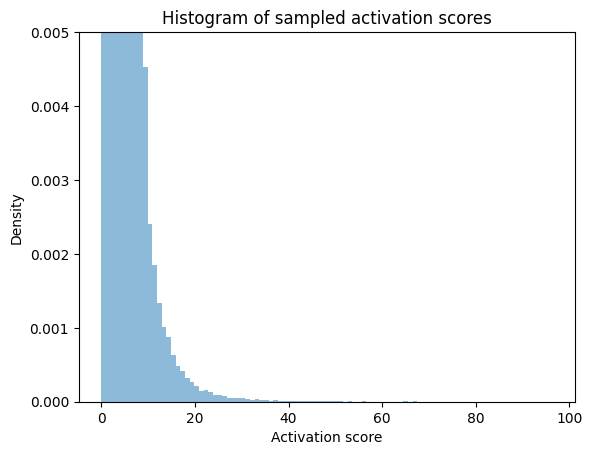

In [15]:
scores_sample = sample_scores(size=1_000_000, func='mound')
nbins = int(np.max(scores_sample[:,0])-np.min(scores_sample[:,0])+1)
hist = plt.hist(scores_sample[:,0], bins=nbins, density=True, alpha=0.5)
plt.ylim(top=0.005)
plt.xlabel("Activation score")
plt.ylabel("Density")
plt.title("Histogram of sampled activation scores")

## Visaualization of different acceptance probability 

We visualize the acceptance probability functions for a very dense linear sampling of the range of scores. This is still two order of magnitude less data than the number of samples in the mixture sample.

In [16]:
scores = np.linspace(scores_sample[:,0].min(), scores_sample[:,0].max(), num=10000, endpoint=True)

The linear sampling isn't suitable for creating a score distribution histogram on the fly, we need to create it in advance from the original mixture sample.

In [17]:
histkde = HistKDE(scores_sample[:,0], bins=200)

Visualize a number of different acceptance probability functions:

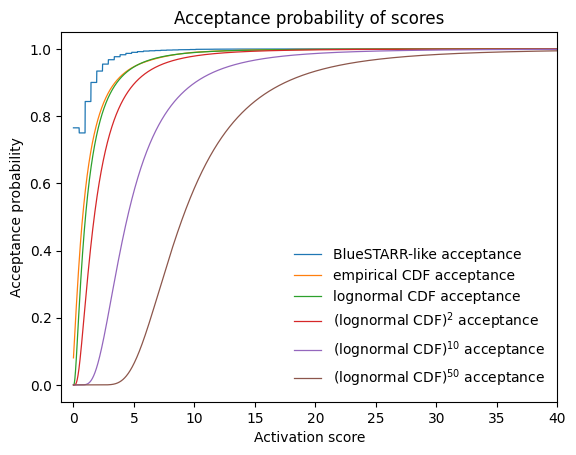

In [24]:
scores = np.linspace(scores_sample[:,0].min(), scores_sample[:,0].max(), num=10000, endpoint=True)
plt.plot(scores, accept_hist_pdf(scores, kde=histkde, interpolate=False),
         linewidth=0.9, label="BlueSTARR-like acceptance")
plt.plot(scores, accept_hist_cdf(scores, kde=histkde, interpolate=True),
         linewidth=0.9, label="empirical CDF acceptance")
plt.plot(scores, accept_cdf(scores, s=1, scale=1),
         linewidth=0.9, label="lognormal CDF acceptance")
plt.plot(scores, accept_cdf(scores, postfunc=np.square, s=1, scale=1),
         linewidth=0.9, label="(lognormal CDF)$^{2}$ acceptance")
plt.plot(scores, accept_cdf(scores, postfunc=lambda x: np.power(x, 10), s=1, scale=1),
         linewidth=0.9, label="(lognormal CDF)$^{10}$ acceptance")
plt.plot(scores, accept_cdf(scores, postfunc=lambda x: np.power(x, 50), s=1, scale=1),
         linewidth=0.9, label="(lognormal CDF)$^{50}$ acceptance")
# plt.xlim(left=scores_sample.min(), right=scores_sample.max())
plt.xlim(left=-1, right=40)
plt.xlabel("Activation score")
plt.ylabel("Acceptance probability")
plt.title("Acceptance probability of scores")
plt.legend(frameon=False)

## Performing biased downsampling and assessing the results

Define a function that takes a sample and an acceptance probability function, performs the sampling according to the acceptance probabilities, and returns the resulting (sub)sample.

In [19]:
def sample_scores_accept(scores, accept_probs, frac=0.05):
    rng = np.random.default_rng()
    accept_probs = accept_probs / accept_probs.sum()
    return rng.choice(scores, size=int(len(scores) * frac), replace=False, p=accept_probs)

Collect results from a number of different acceptance probability functions.

In [25]:
def downsample(scores_sample, kde=histkde, frac=0.05):
    method_labels = [ "BlueSTARR", "ECDF", "lognormal CDF", "(lognormal CDF)$^{2}$", "(lognormal CDF)$^{5}$", "(lognormal CDF)$^{10}$", "(lognormal CDF)$^{50}$"]  # "BlueSTARR",
    scores_biased = (
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_hist_pdf(scores_sample, kde=kde, interpolate=False)),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_hist_cdf(scores_sample, kde=kde, interpolate=True)),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, s=1, scale=1)),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, s=1, scale=1, postfunc=np.square)),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, s=1, scale=1, postfunc=lambda x: np.power(x, 5))),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, s=1, scale=1, postfunc=lambda x: np.power(x, 10))),
        sample_scores_accept(scores_sample, frac=frac,
                             accept_probs=accept_cdf(scores_sample, s=1, scale=1, postfunc=lambda x: np.power(x, 50))),
    )
    return scores_biased, method_labels

In [21]:
# def downsample(scores_sample, kde=histkde, frac=0.1):
#     method_labels = ["BlueSTARR", "lognormal CDF", "(lognormal CDF)$^{2}$", "(lognormal CDF)$^{10}$"]
#     scores_biased = (
#         sample_scores_accept(scores_sample, frac=frac,
#                              accept_probs=accept_hist_pdf(scores_sample, kde=kde, interpolate=False)),
#         sample_scores_accept(scores_sample, frac=frac,
#                              accept_probs=accept_cdf(scores_sample, s=1, scale=1)),
#         sample_scores_accept(scores_sample, frac=frac,
#                              accept_probs=accept_cdf(scores_sample, s=1, scale=1, postfunc=np.square)),
#         sample_scores_accept(scores_sample, frac=frac,
#                              accept_probs=accept_cdf(scores_sample, s=1, scale=1, postfunc=lambda x: np.power(x, 10))),
#     )
#     return scores_biased, method_labels

### Histograms of the collected samples

Grouped barcharts for each histogram bin:

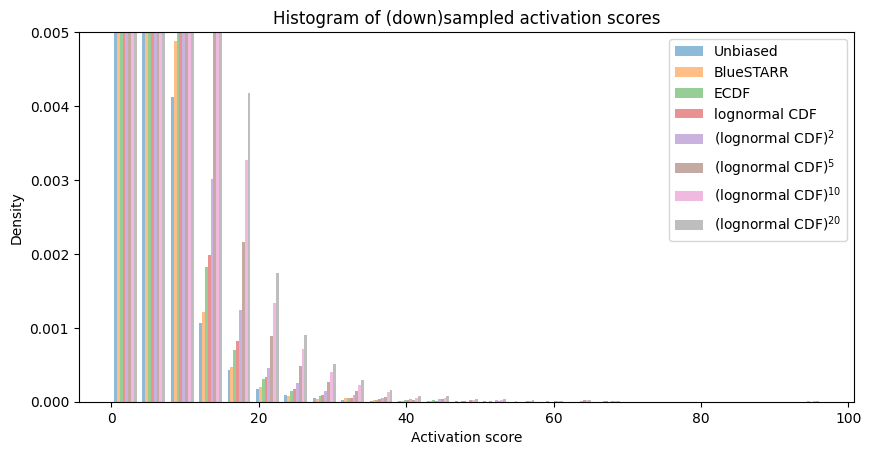

In [22]:
fig, ax = plt.subplots()
fig.set_figwidth(10)

scores_biased, method_labels = downsample(scores_sample, frac=0.1)

hist = ax.hist([x[:,0] for x in (scores_sample,) + scores_biased], bins=25, density=True, alpha=0.5,
               label=["Unbiased"] + method_labels)
ax.set_ylim(top=0.005)
ax.set_xlabel("Activation score")
ax.set_ylabel("Density")
ax.set_title(f"Histogram of (down)sampled activation scores")
ax.legend()


### Assessing the fraction of positives in the biased samples

In [ ]:
print(f'V-shape activation function with scaling for Blue-STARR activation function')
fracs = [0.8]
scores_sample = sample_scores(size=1_000_000, func='v-shape')
histkde=HistKDE(scores_sample[:,0], bins=200)
print('# negative samples',len(scores_sample[scores_sample[:,0]<0,]))
posfrac = (~np.isnan(scores_sample[:,1])).sum() / len(scores_sample)
print(f"Unbiased sample: {posfrac:.2%} positives")
for frac in fracs:
    scores_biased, method_labels = downsample(scores_sample, frac=frac)
    print(f"Biased downsampling to {frac:.1%}:")
    for sample, method_label in zip(scores_biased, method_labels):
        posfrac = (~np.isnan(sample[:,1])).sum() / len(sample)
        print(f"  {method_label}: {posfrac:.2%} positives")
        print('  # negative samples after biased downsampling',len(sample[sample[:,0]<0,]))

In [ ]:
print(f'exp-fit-1 with scaling for Blue-STARR activation function')
fracs = [0.27]
scores_sample = sample_scores(size=1_000_000, func='exp-fit-1')
histkde=HistKDE(scores_sample[:,0], bins=100)
print('# negative samples',len(scores_sample[scores_sample[:,0]<0,]))
posfrac = (~np.isnan(scores_sample[:,1])).sum() / len(scores_sample)
print(f"Unbiased sample: {posfrac:.2%} positives")
for frac in fracs:
    scores_biased, method_labels = downsample(scores_sample, frac=frac)
    print(f"Biased downsampling to {frac:.1%}:")
    for sample, method_label in zip(scores_biased, method_labels):
        posfrac = (~np.isnan(sample[:,1])).sum() / len(sample)
        print(f"  {method_label}: {posfrac:.2%} positives")
        print('  # negative samples after biased downsampling',len(sample[sample[:,0]<0,]))

In [26]:
print(f'mound shape signal')
scores_sample = sample_scores(size=1_000_000, func='mound')
fracs = [0.27]
posfrac = (~np.isnan(scores_sample[:,1])).sum() / len(scores_sample)
print(f"Unbiased sample: {posfrac:.2%} positives")
for frac in fracs:
    scores_biased, method_labels = downsample(scores_sample, frac=frac)
    print(f"Biased downsampling to {frac:.1%}:")
    for sample, method_label in zip(scores_biased, method_labels):
        posfrac = (~np.isnan(sample[:,1])).sum() / len(sample)
        print(f"  {method_label}: {posfrac:.2%} positives")

mound shape signal
Unbiased sample: 0.50% positives
Biased downsampling to 27.0%:
  BlueSTARR: 0.58% positives
  ECDF: 0.72% positives
  lognormal CDF: 0.82% positives
  (lognormal CDF)$^{2}$: 1.12% positives
  (lognormal CDF)$^{5}$: 1.59% positives
  (lognormal CDF)$^{10}$: 1.69% positives
  (lognormal CDF)$^{50}$: 1.69% positives


In [ ]:
print(f'bowl shape signal')
scores_sample = sample_scores(size=1_000_000, func='bowl')
fracs = [0.27]
posfrac = (~np.isnan(scores_sample[:,1])).sum() / len(scores_sample)
print(f"Unbiased sample: {posfrac:.2%} positives")
for frac in fracs:
    scores_biased, method_labels = downsample(scores_sample, frac=frac)
    print(f"Biased downsampling to {frac:.1%}:")
    for sample, method_label in zip(scores_biased, method_labels):
        posfrac = (~np.isnan(sample[:,1])).sum() / len(sample)
        print(f"  {method_label}: {posfrac:.2%} positives")

In [ ]:
print(f'cliff shape signal')
scores_sample = sample_scores(size=1_000_000, func='cliff')
fracs = [0.27]
posfrac = (~np.isnan(scores_sample[:,1])).sum() / len(scores_sample)
print(f"Unbiased sample: {posfrac:.2%} positives")
for frac in fracs:
    scores_biased, method_labels = downsample(scores_sample, frac=frac)
    print(f"Biased downsampling to {frac:.1%}:")
    for sample, method_label in zip(scores_biased, method_labels):
        posfrac = (~np.isnan(sample[:,1])).sum() / len(sample)
        print(f"  {method_label}: {posfrac:.2%} positives")

In [ ]:
print(f'periodicity shape signal')
scores_sample = sample_scores(size=1_000_000, func='periodicity')
fracs = [0.27]
posfrac = (~np.isnan(scores_sample[:,1])).sum() / len(scores_sample)
print(f"Unbiased sample: {posfrac:.2%} positives")
for frac in fracs:
    scores_biased, method_labels = downsample(scores_sample, frac=frac)
    print(f"Biased downsampling to {frac:.1%}:")
    for sample, method_label in zip(scores_biased, method_labels):
        posfrac = (~np.isnan(sample[:,1])).sum() / len(sample)
        print(f"  {method_label}: {posfrac:.2%} positives")

In [21]:
print(f'hill shape signal')
scores_sample = sample_scores(size=1_000_000, func='hill')
fracs = [0.27]
posfrac = (~np.isnan(scores_sample[:,1])).sum() / len(scores_sample)
print(f"Unbiased sample: {posfrac:.2%} positives")
for frac in fracs:
    scores_biased, method_labels = downsample(scores_sample, frac=frac)
    print(f"Biased downsampling to {frac:.1%}:")
    for sample, method_label in zip(scores_biased, method_labels):
        posfrac = (~np.isnan(sample[:,1])).sum() / len(sample)
        print(f"  {method_label}: {posfrac:.2%} positives")

hill shape signal
Unbiased sample: 0.50% positives
Biased downsampling to 27.0%:
  BlueSTARR: 0.65% positives
  ECDF: 0.74% positives
  lognormal CDF: 0.87% positives
  (lognormal CDF)$^{2}$: 1.20% positives
  (lognormal CDF)$^{5}$: 1.74% positives
  (lognormal CDF)$^{10}$: 1.85% positives


In [ ]:
scores = np.linspace(scores_sample[:,0].min(), scores_sample[:,0].max(), num=10000, endpoint=True)
plt.plot(scores, accept_hist_pdf(scores, kde=histkde, interpolate=False),
         linewidth=0.9, label="BlueSTARR-like acceptance")
plt.plot(scores, accept_hist_cdf(scores, kde=histkde, interpolate=True),
         linewidth=0.9, label="empirical CDF acceptance")
plt.plot(scores, accept_cdf(scores, s=1, scale=1),
         linewidth=0.9, label="lognormal CDF acceptance")
plt.plot(scores, accept_cdf(scores, postfunc=np.square, s=1, scale=1),
         linewidth=0.9, label="(lognormal CDF)$^{2}$ acceptance")
plt.plot(scores, accept_cdf(scores, postfunc=lambda x: np.power(x, 50), s=1, scale=1),
         linewidth=0.9, label="(lognormal CDF)$^{10}$ acceptance")
# plt.xlim(left=scores_sample.min(), right=scores_sample.max())
plt.xlim(left=-1, right=40)
plt.xlabel("Activation score")
plt.ylabel("Acceptance probability")
plt.title("Acceptance probability of scores - periodicity shape")
plt.legend(frameon=False)

## Appendix: Comparison of different histogram-based empirical PDF and CDF implementations

In [ ]:
histkde = HistKDE(scores_sample[:,0], bins=200)
gauss_kde = gaussian_kde(histkde.mids, bw_method=0.05, weights=histkde.probs)

In [ ]:
scores = np.linspace(0, scores_sample[:,0].max()+1, 10000)
plt.plot(scores, 1-gauss_kde.pdf(scores), label="1 - Gaussian KDE PDF")
plt.plot(scores, histkde.cdf(scores), label="Histogram CDF (interpolated)")
plt.plot(scores, histkde.cdf(scores, interpolate=False), label="Histogram CDF")
plt.plot(histkde.mids, histkde.cum_probs, label="Histogram cumulative")
plt.xlim(left=-1, right=30)
plt.xlabel("Activation score")
plt.ylabel("Density")
plt.title("Gaussian vs. Histogram KDE (both from 200 bins)")
plt.legend()
